In [ ]:
import os
import gc
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import json
import enum
import sklearn.preprocessing
import argparse
# import tensorflow.compat.v1 as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import pickle
import math
from scipy import interpolate
import random
import time
from lightgbm import LGBMRegressor
# import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor


In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 12
rcParams.update({'font.size': fsize})

### P_data_new

In [ ]:
with open(f'sample_ex1.p', 'rb') as f:
    df_all = pickle.load(f)

In [ ]:
list_ground = list(df_all)
print(list_ground)
df_new = pd.concat([df_all[ground] for ground in list_ground], ignore_index=True)
print(list(df_new))
print(len(df_new))

In [ ]:
list_input_time = ['disp_ground']
list_output_time = []
list_static = []

for k in list(df_new):
  if (str(k)[:4] == 'disp') & (str(k)[-1] != 'd'):
    list_output_time.append(k)

  if str(k)[:4] != 'disp':
    list_static.append(k)

print(list_output_time)

In [ ]:
max_disp = [np.max(np.abs(df_new[list_output_time[-1]][idx])) for idx in range(len(df_new))]
df_new['max_disp'] = max_disp

In [ ]:
L_all, L_out = 800, 750
sliding_step = 750
list_time_series = list_input_time + list_output_time
L_in = L_all-L_out
N_input= len(list_input_time)
N_output= len(list_output_time)
N_static = len(list_static)
N_time_series = len(list_input_time)+len(list_output_time)+1

In [ ]:
static_scaler = sklearn.preprocessing.StandardScaler().fit(df_new[list_static].values)
target = np.array([df_new[i][0] for i in list_output_time]).T
target_scaler = sklearn.preprocessing.StandardScaler().fit(target)
real = np.array([df_new[i][0] for i in list_time_series]).T
real_scaler = sklearn.preprocessing.StandardScaler().fit(real)

In [ ]:
def prepare_data(x, N1, N2, j = 2):
# N1: L_input, N2: L_output, j: sliding_step between 2 segments
  N0 = len(x)
  xxx = np.stack([x[i:N0 - N1+i+1:j, :] for i in range(N1)], axis=1)
  y = xxx[:,-N2:,-len(list_output_time):]

  return np.array(xxx), np.array(y)

In [ ]:
### Retrain model with selected data
def gen_data_AI(df_new, list_idx):
  list_static_data = []
  list_X_data = []
  list_Y_label = []

  for idx in list_idx:
    len_signal = np.min([len(df_new[k][idx]) for k in list_time_series ])
    static = np.array([df_new[k][idx] for k in list_static ]).reshape(1,-1)
    scaled_static = static_scaler.transform(static)
    signal = np.array([df_new[k][idx][:len_signal] for k in list_time_series ]).T
    signal = np.pad(signal,((L_all,0),(0,0)),constant_values=0.0)
    scaled_signal = real_scaler.transform(signal)

    X_data, Y_label = prepare_data(scaled_signal, L_all, L_out, j = sliding_step)
    list_X_data.append(X_data)
    list_Y_label.append(Y_label)
    list_static_data.append(np.repeat(scaled_static, len(Y_label), axis = 0))



  redata = np.concatenate(list_X_data, axis = 0)
  relabel = np.concatenate(list_Y_label, axis = 0)
  restatic = np.concatenate(list_static_data, axis = 0)
  xx = np.zeros((np.shape(redata)[0], np.shape(redata)[1], 1))
  xx[:,:np.shape(restatic)[-1],0]=restatic
  retrain_data = np.concatenate((redata, xx), axis=-1)

  return retrain_data, relabel, restatic

In [ ]:
gc.collect(2)
gc.collect(2)

0

In [ ]:
def inference_2(model, df_new, idx):
  len_signal = np.min([len(df_new[k][idx]) for k in list_time_series ])
  static = np.array([df_new[k][idx] for k in list_static ]).reshape(1,-1)
  scaled_static = static_scaler.transform(static)
  signal = np.array([df_new[k][idx][:len_signal] for k in list_time_series ]).T
  signal = np.pad(signal,((L_all,0),(0,0)),constant_values=0.0)
  scaled_signal = real_scaler.transform(signal)

  data, label = prepare_data(scaled_signal, L_all, L_out, j = L_out)
  static = np.repeat(scaled_static, len(label), axis = 0)    # static: (N_segment, N_static)

  # combine static to time-varying input
  xx = np.zeros((data.shape[0], L_all, 1))
  xx[:,:N_static,0]=static
  x_input = np.concatenate((data, xx), axis=-1)
  L_signal = (np.shape(data)[0]-1)*L_out

  # initial a long output time-series with zero
  y_predict_all = np.zeros((L_signal+L_all, N_output))

  # Starting prediction loop
  itx = L_all
  for j in range(int(L_signal/L_out)+1):
    x_input[j,:L_all, N_input:N_time_series-1] = y_predict_all[itx-L_all:itx,:]
    y_pred = model.predict(x_input[j:j+1,:,:], batch_size=128, verbose=0)
    y_predict_all[itx-L_out:itx,:] = y_pred[:,:,:]
    itx += L_out


  # Rescale back time-varying output
  y_predict_all = target_scaler.inverse_transform(y_predict_all)

  return y_predict_all

### Train DL model

In [ ]:
idx_train = np.random.choice(5000, size=500, replace=False)  # False: 1 value 1 time
idx_valid = np.arange(5000,10000)
print(len(idx_train), len(idx_valid))
train_data, train_label, train_static = gen_data_AI(df_new, idx_train)
val_data, val_label, val_static = gen_data_AI(df_new, idx_valid)
print(train_data.shape, val_data.shape)

500 5000
(2500, 800, 5) (25000, 800, 5)


In [ ]:
all_inputs = tf.keras.layers.Input(shape=(L_all, N_time_series,))
all_callbacks = [tf.keras.callbacks.ModelCheckpoint( 'h_not_good.check', monitor='val_loss', save_best_only=True, save_weights_only=True)]

In [ ]:
def tf_loss(y, y_pred):
  # q_loss = tf.abs(y - y_pred)
  q_loss = tf.square(y - y_pred)

  # return tf.reduce_sum(tf.reduce_sum(q_loss, axis=-1), axis=-1)
  return tf.math.sqrt(tf.reduce_sum(tf.reduce_sum(q_loss, axis=-1), axis=-1))


In [ ]:
def train_model(model, train_data, train_label, val_data, val_label, list_lr=[0.01, 0.005, 0.001], Nepoch=20):
  t_start = time.time()
  for lr in list_lr:
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=tf.keras.losses.mae, optimizer=adam)  #okie : MSE, MSLE, MAE
    history = model.fit( x=train_data, y=train_label, epochs=Nepoch, batch_size=512,
            validation_data=(val_data, val_label), callbacks=all_callbacks, shuffle=True, verbose = False)

  t_end = time.time()
  t_cal = t_end - t_start

  return model, history, t_cal


In [ ]:
def tft():
  output0 = tf.zeros_like(all_inputs[:, L_in:, N_input:N_time_series-1] )
  historical_features = tf.keras.backend.concatenate([all_inputs[:, :L_in, N_input:N_time_series-1], output0], axis=1)
  future_features = all_inputs[:, :, :N_input]
  input_static = tf.expand_dims(all_inputs[:, :N_static, -1] , axis = 1)
  static_features = tf.keras.backend.repeat_elements(input_static, L_all, axis=1)  # add static features to every time steps
  features = tf.keras.backend.concatenate([historical_features, future_features, static_features], axis=2)
  ### features: (batch, timesteps, feature)
  features = tf.keras.layers.Conv1D(filters=32, kernel_size=32, strides=4, padding='same', activation='relu', data_format="channels_last")(features)
  features = tf.keras.layers.GRU(units = 32, return_sequences=True, return_state=False)(features) # inputs = (32, 10, 8) --> outputs: (32, 10, 16)
  features = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32, value_dim=32)(features, features)


  features = tf.transpose(features, perm=[0, 2, 1])
  features = tf.keras.layers.Dense(units=L_out, activation='relu')(features)
  features = tf.transpose(features, perm=[0, 2, 1])
  features = tf.keras.layers.Dense(units=N_output)(features)

  return features


In [ ]:
# First training
gc.collect(2)
gc.collect(2)
outputs = tft()
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
# model, history, t_cal = train_model(model, train_data, train_label, val_data, val_label, Nepoch=50)
with open(f'tuned_DL_{ex_name}.p','rb') as f:
  model = pickle.load(f)

model, history, t_cal = train_model(model, train_data, train_label, val_data, val_label, Nepoch=1)
retrain_data, retrain_label = train_data, train_label
print(np.min(history.history['val_loss']), t_cal)


0.045280084013938904 36.59062433242798


In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 16
rcParams.update({'font.size': fsize})

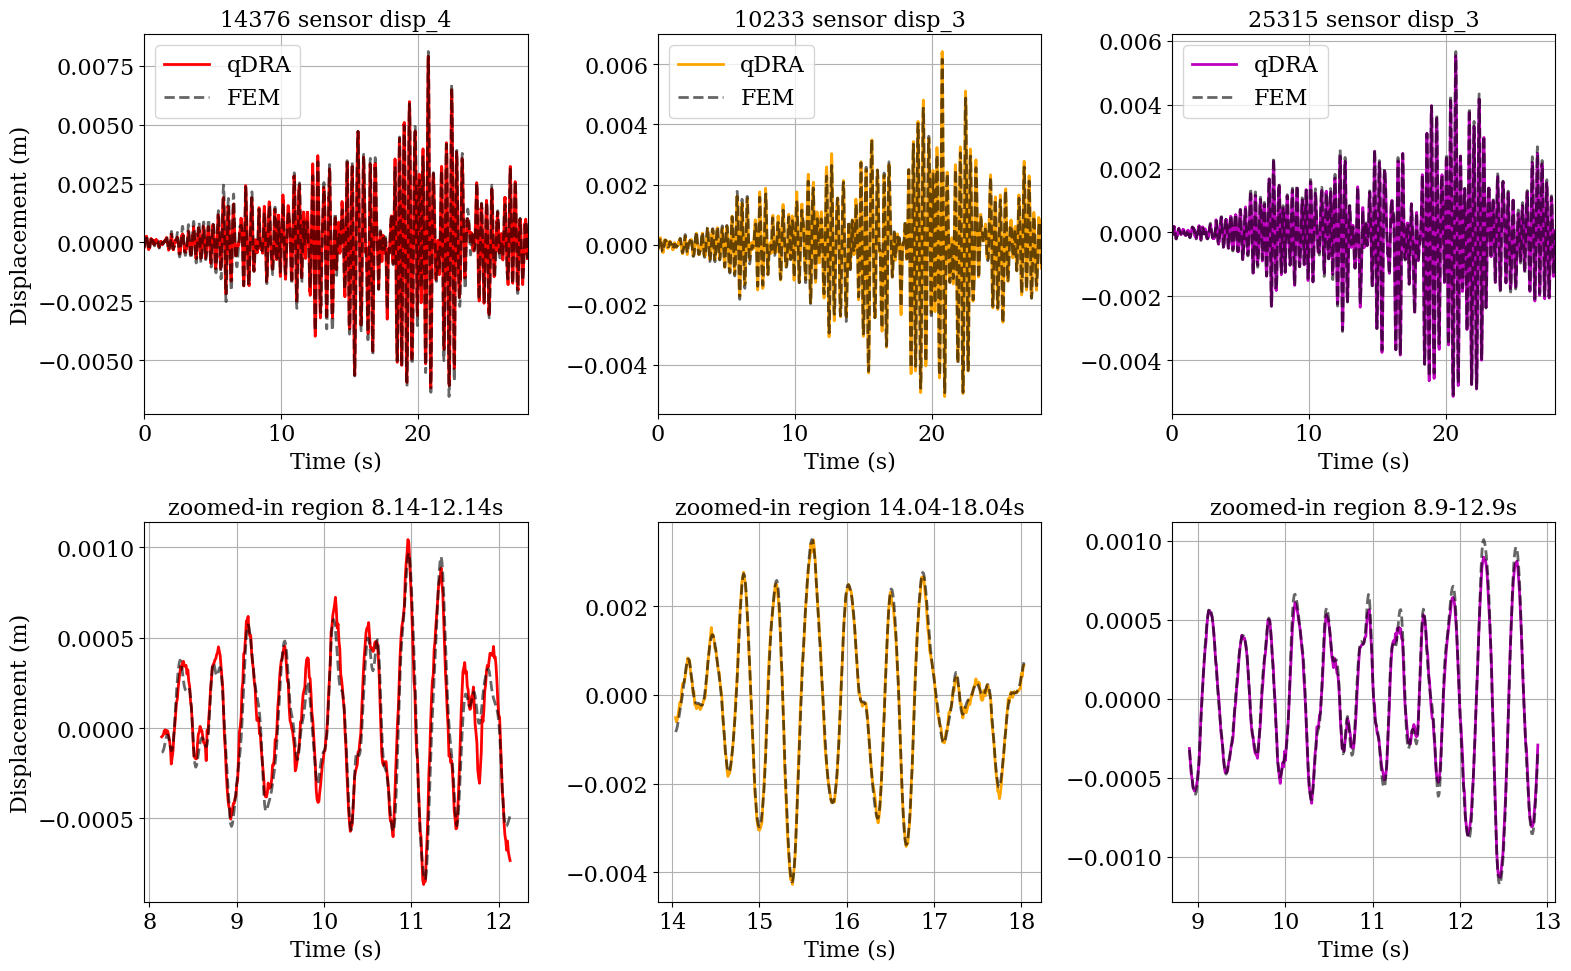

In [ ]:
plt.figure(figsize=(16,10))
# list_ip = np.random.randint(0,len(df_new), 3)
list_ip = [14376, 10233, 25315]

list_color = ['r', 'orange', 'm']
for i,ip in enumerate(list_ip):
  plt.subplot(231+i)
  y_predict_all = inference_2(model, df_new, ip)
  i_s = np.random.randint(N_output)
  length = len(df_new[list_output_time[i_s]][ip])
  t= np.arange(0,len(df_new[list_output_time[i_s]][ip][200:]))*0.01
  plt.plot(t, y_predict_all[L_all:L_all+length,i_s][200:],list_color[i], linewidth=2)
  plt.plot(t, df_new[list_output_time[i_s]][ip][200:],'--k', alpha = 0.6, linewidth=2)
  plt.legend(['qDRA', 'FEM'], loc=0)
  plt.title(f'{ip} sensor {list_output_time[i_s]}', fontsize=16)
  plt.xlabel('Time (s)')
  if i==0:
    plt.ylabel('Displacement (m)')
  plt.xlim(0,28)
  plt.grid(True)


  plt.subplot(231+i+3)
  y_predict_all = inference_2(model, df_new, ip)
  i_s = np.random.randint(N_output)
  length = len(df_new[list_output_time[i_s]][ip])
  t= np.arange(0,len(df_new[list_output_time[i_s]][ip][200:]))*0.01
  # t1, t2 = 800, 1200
  t1 = np.random.randint(0,2200)
  t2 = t1+400
  yy = y_predict_all[L_all:L_all+length,i_s][200:]
  plt.plot(t[t1:t2], yy[t1:t2],list_color[i], linewidth=2)
  yy = df_new[list_output_time[i_s]][ip][200:]
  plt.plot(t[t1:t2], yy[t1:t2],'--k', alpha = 0.6, linewidth=2)
  plt.title(f'zoomed-in region {t1/100}-{t2/100}s', fontsize=16)
  plt.xlabel('Time (s)')
  if i==0:
    plt.ylabel('Displacement (m)')
  plt.grid(True)


plt.tight_layout();
plt.savefig(f'{ex_name}_1.png',dpi=400)

### Uncertainty quantification

In [ ]:

idx_train0 = idx_train.copy()
idx_train = idx_train0.copy()
print(len(idx_train))
train_data, train_label, train_static = gen_data_AI(df_new, idx_train)


In [ ]:
N_rep = 10
N_range = 10
Nsample_range = 100
Ncandidate_range = 2

In [ ]:
y_quantile_ref9 = []
for ip in idx_train:
  y_ref = df_new[list_output_time[-1]][ip]
  yy = np.quantile(y_ref, 0.95)
  y_quantile_ref9.append(yy)

list_thr = np.linspace(np.max(y_quantile_ref9), np.min(y_quantile_ref9),10)

In [ ]:
X_all = df_new.iloc[:5000][list_static].values
y_all = df_new.iloc[:5000]['max_disp'].values
X_train = df_new.iloc[idx_train][list_static].values
y_train = df_new.iloc[idx_train]['max_disp'].values
X_valid = df_new.iloc[idx_valid][list_static].values
y_valid = df_new.iloc[idx_valid]['max_disp'].values

In [ ]:
def Ufunc_k(y_GP, std, k = 10):
  U = np.abs(y_GP/(std+1e-6))
  idx = np.argpartition(U, k)[:k]

  return idx, U[idx]


In [ ]:
model_0 = LGBMRegressor(verbosity = -1)
model_05 = LGBMRegressor(objective='quantile', alpha=0.05, verbosity = -1)
model_95 = LGBMRegressor(objective='quantile', alpha=0.95, verbosity = -1)

In [ ]:
model_0.fit(X_train, y_train)
model_05.fit(X_train, y_train)
model_95.fit(X_train, y_train)

In [ ]:
y_05 = model_05.predict(X_all)
y_95 = model_95.predict(X_all)


In [ ]:
dict_U = {}
for i, thr in enumerate(list_thr):
  y_GP = thr - model_0.predict(X_all)
  std = np.abs(y_95-y_05)/4.0
  idx, U = Ufunc_k(y_GP, std, k=Nsample_range)
  dict_U[f'thr_{i}'] = {'idx':idx, 'U':U}

In [ ]:
dict_list_idx = {}
for irep in range(N_rep):
  dict_list_idx[irep] = np.array([dict_U[f'thr_{i}']['idx'][irep*Ncandidate_range:(irep+1)*Ncandidate_range] for i in range(len(list_thr))]).reshape(-1)

In [ ]:
### Retrain model with selected data
list_idx = idx_train0[::3]
retrain_data, retrain_label, restatic = gen_data_AI(df_new, list_idx)
print(len(list_idx), len(retrain_data), len(val_data))
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model, history, t_cal = train_model(model, retrain_data, retrain_label, val_data, val_label, list_lr=[0.001], Nepoch=5)
print(np.min(history.history['val_loss']), t_cal)
gc.collect(2)
gc.collect(2)

In [ ]:
for i_rep in range(N_rep):
  list_idx1 = np.random.choice(5000, size=20, replace=False)
  # list_idx = np.concatenate([list_idx, dict_list_idx[irep]])
  list_idx = np.concatenate([list_idx, list_idx1])
  print(len(list_idx))
  retrain_data, retrain_label, restatic = gen_data_AI(df_new, list_idx)
  model, history, t_cal = train_model(model, retrain_data, retrain_label, val_data, val_label, list_lr=[0.001], Nepoch=5)
  gc.collect(2)
  gc.collect(2)
  print(np.min(history.history['val_loss']), t_cal)

In [ ]:
### Retrain model with selected data
list_idx = idx_train0[::3]
retrain_data, retrain_label, restatic = gen_data_AI(df_new, list_idx)
print(len(list_idx), len(retrain_data), len(val_data))
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model, history, t_cal = train_model(model, retrain_data, retrain_label, val_data, val_label, list_lr=[0.001], Nepoch=5)
print(np.min(history.history['val_loss']), t_cal)
gc.collect(2)
gc.collect(2)

In [ ]:
for i_rep in range(N_rep):
  # list_idx1 = np.random.choice(5000, size=20, replace=False)
  list_idx1 = dict_list_idx[irep]
  list_idx = np.concatenate([list_idx, list_idx1])
  print(len(list_idx))
  retrain_data, retrain_label, restatic = gen_data_AI(df_new, list_idx)
  model, history, t_cal = train_model(model, retrain_data, retrain_label, val_data, val_label, list_lr=[0.001], Nepoch=5)
  gc.collect(2)
  gc.collect(2)
  print(np.min(history.history['val_loss']), t_cal)

187
0.030823130160570145 9.310521841049194
207
0.03377470746636391 12.899630784988403
227
0.031193602830171585 12.405216693878174
247
0.03189415857195854 12.139062643051147
267
0.031417395919561386 9.48877215385437
287
0.031946904957294464 12.325622797012329
307
0.03163018450140953 12.21396517753601
327
0.03189711272716522 10.396506071090698
347
0.03192230314016342 12.22473430633545
367
0.031915564090013504 12.244933366775513


In [ ]:
with open(f'tuned_DL_{ex_name}.p','wb') as f:
  pickle.dump(model, f)

### Probability distribution of prediction

In [ ]:
%%time
Nsample = 10000

list_predict = []
for ip in range(Nsample):
  if ip % 100 ==0:
    print(ip)

  y_predict_all = inference_2(model, df_new, ip)
  list_predict.append(y_predict_all)

list_predict=np.array(list_predict)
list_predict.shape

In [ ]:
with open('list_predict.p','rb') as f:
  list_predict = pickle.load(f)

Nsample = len(list_predict)

In [ ]:
type(list_predict), list_predict.shape

(numpy.ndarray, (10000, 3800, 3))

In [ ]:
%%time
list_ymax = []
list_ymax_ref = []
for ip in range(Nsample):
  y_ref = df_new[list_output_time[-1]][ip]
  ymax = np.max(np.abs(y_ref))
  list_ymax_ref.append(ymax)
  ymax = np.max(np.abs(list_predict[ip,:,-1]))
  list_ymax.append(ymax)

list_ymax = np.max(np.abs(list_predict[:,:,-1]), axis=1);

y_quantile_predict = []
y_quantile_ref = []
for ip in range(Nsample):
  yy = np.quantile(list_predict[ip,:,-1], 0.05)
  y_quantile_predict.append(yy)
  y_ref = df_new[list_output_time[-1]][ip]
  yy = np.quantile(y_ref, 0.05)
  y_quantile_ref.append(yy)


y_quantile_predict9 = []
y_quantile_ref9 = []
for ip in range(Nsample):
  yy = np.quantile(list_predict[ip,:,-1], 0.95)
  y_quantile_predict9.append(yy)
  y_ref = df_new[list_output_time[-1]][ip]
  yy = np.quantile(y_ref, 0.95)
  y_quantile_ref9.append(yy)

y_mean_predict = []
y_mean_predict = np.mean(list_predict[:,:,-1], axis=1)

y_mean_ref = []
for ip in range(Nsample):
  y_ref = df_new[list_output_time[-1]][ip]
  yy = np.mean(y_ref)
  y_mean_ref.append(yy)

CPU times: user 9.93 s, sys: 256 ms, total: 10.2 s
Wall time: 13.9 s


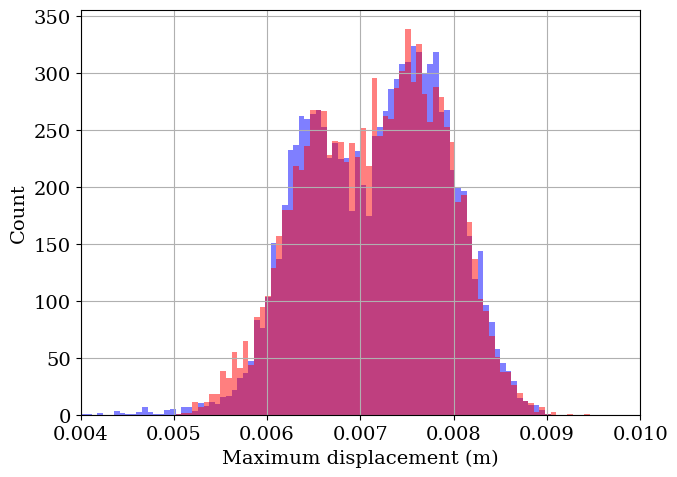

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(list_ymax, bins=100,range = [0.004, 0.010], color='blue', alpha=0.5);
plt.hist(list_ymax_ref, bins=100, range = [0.004, 0.010], color='red', alpha=0.5);
plt.xlim(0.004,0.01)
plt.xlabel('Maximum displacement (m)')
plt.ylabel('Count');
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{ex_name}_max.png',dpi=400)

### Reliability

In [ ]:
list_thr = np.linspace(np.max(list_ymax_ref), np.min(list_ymax_ref),25)

In [ ]:
factor = 1.0

Pf_ref = []
Ri_ref = []
for thr in list_thr:
    Pf = len(np.where(list_ymax_ref > thr )[0])/len(list_ymax_ref)
    Pf_ref.append(Pf)
    Ri_ref.append(norm.isf(Pf))

list_ymax = np.array(list_ymax)
Pf_predict = []
Ri_predict = []
for thr in list_thr:
    Pf = len(np.where(list_ymax*factor > thr )[0])/len(list_ymax)
    Pf_predict.append(Pf)
    Ri_predict.append(norm.isf(Pf))


In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 14
rcParams.update({'font.size': fsize})

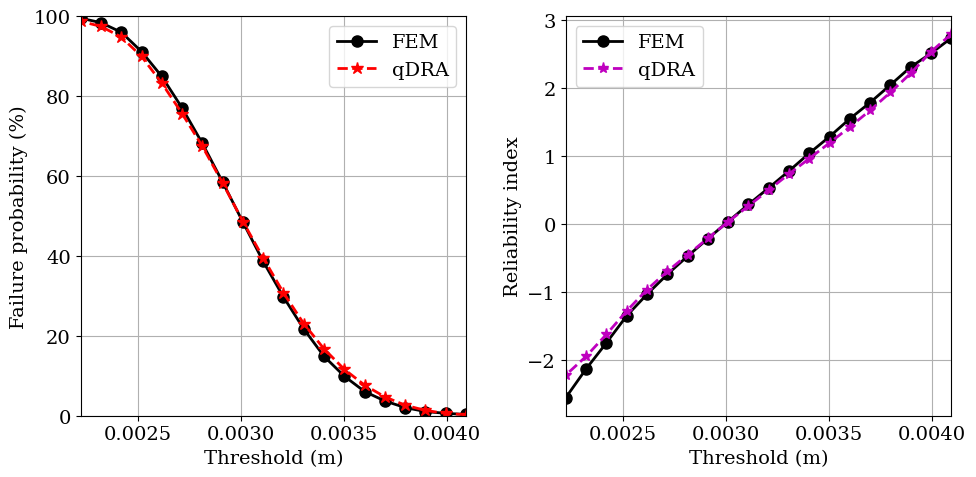

In [ ]:
i1, i2 = 3, 2
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(list_thr[i1:-i2], np.array(Pf_ref[i1:-i2])*100, '-ok', linewidth=2, markersize=8)
plt.plot(list_thr[i1:-i2], np.array(Pf_predict[i1:-i2])*100, '--*r', linewidth=2, markersize=9)
# plt.xticks(rotation=45)
plt.xlabel('Threshold (m)')
plt.ylabel('Failure probability (%)')
plt.xlim(list_thr[-i2-1],list_thr[i1])
plt.ylim(0, 100)
plt.legend(['FEM','qDRA'])
plt.grid(True)
plt.subplot(122)
plt.plot(list_thr[i1:-i2], Ri_ref[i1:-i2], '-ok', linewidth=2, markersize=8)
plt.plot(list_thr[i1:-i2], Ri_predict[i1:-i2], '--*m', linewidth=2, markersize=8)
# plt.xticks(rotation=45)
plt.xlabel('Threshold (m)')
plt.ylabel('Reliability index')
plt.legend(['FEM','qDRA'])
plt.xlim(list_thr[-i2-1],list_thr[i1])
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{ex_name}_Pf_max.png',dpi=400)